In [1]:
import pandas as pd
import geopandas as gpd
import ast
import data_processing
import utils
import visualization
from consts import *
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [2]:
estimated_production_by_roof = pd.read_csv(ROOFS_PATH)


### Exploring the real buildings


In [3]:
real_roofs_measures = pd.read_csv(
    DEVICES_MAPPED_PATH,
    usecols=[ETAK_ID, ADDRESS, ORIENTATION, PV_AREA_M2]
)


In [4]:
real_roofs = estimated_production_by_roof[estimated_production_by_roof[ETAK_ID].isin(real_roofs_measures[ETAK_ID].unique())].loc[
    :,
    [ETAK_ID, ROOF_ID, LAT, LON, ORIENTATION, TILT, AZIMUTH, ROOF_AREA,
        PV_AREA_M2, ANNUAL_KWH, MONTHLY_AVERAGE_KWH, POINTS] + MONTHS_ABBR_UNITS
]
real_roofs.shape


(44, 24)

In [5]:
real_roofs_with_address = real_roofs.merge(
    real_roofs_measures[[ETAK_ID, ADDRESS]], on=ETAK_ID, how="left")
real_roofs_with_address.drop_duplicates([ETAK_ID, ROOF_ID], inplace=True)
real_roofs_with_address.reset_index(drop=True, inplace=True)


In [6]:
real_roofs_with_address.shape


(44, 25)

In [7]:
real_roofs_with_address[POINTS] = real_roofs_with_address[POINTS].apply(
    lambda x: ast.literal_eval(x))


In [8]:
real_roofs_with_address[POINTS]

0     [[6473607.01, 659392.74, 14.729999999999997], ...
1     [[6473621.13, 659385.94, 15.190000000000005], ...
2     [[6473597.67, 659419.76, 15.270000000000003], ...
3     [[6473608.09, 659391.04, 15.720000000000006], ...
4     [[6473768.93, 659604.19, 14.730000000000004], ...
5     [[6473742.07, 659625.28, 15.350000000000001], ...
6     [[6473768.93, 659604.19, 14.730000000000004], ...
7     [[6473749.94, 659626.33, 18.480000000000004], ...
8     [[6473786.41, 659602.7, 18.25], [6473823.12, 6...
9     [[6473786.41, 659602.7, 18.25], [6473790.43, 6...
10    [[6473825.87, 659826.15, 16.259999999999998], ...
11    [[6473790.27, 659847.9, 16.259999999999998], [...
12    [[6473723.03, 659040.34, 17.090000000000003], ...
13    [[6473777.11, 659010.39, 17.090000000000003], ...
14    [[6474599.77, 659032.65, 16.339999999999996], ...
15    [[6474599.77, 659032.65, 16.339999999999996], ...
16    [[6473876.48, 659707.47, 16.370000000000005], ...
17    [[6473876.48, 659707.47, 16.37000000000000

In [9]:
real_roofs_with_address[AZIMUTH_NEW] = real_roofs_with_address[POINTS].apply(
    lambda x: data_processing.get_angles(data_processing.unit_normal(x[0], x[1], x[2]))[0])


In [10]:
real_roofs_with_address[ORIENTATION_NEW] = real_roofs_with_address.apply(data_processing.get_orientation, axis=1)


In [11]:
real_roofs_with_address[POLYGON] = real_roofs_with_address.apply(data_processing.create_polygon, axis=1)


In [12]:
real_roofs_gdf = gpd.GeoDataFrame(
    real_roofs_with_address[[ETAK_ID, ROOF_ID, ADDRESS,
                             ORIENTATION, ORIENTATION_NEW, POLYGON]].copy(),
    geometry="polygon"
)


In [13]:
orientation_colors = {
    NONE: 'grey',
    NORTH: 'blue',
    SOUTH: 'red',
    EAST: 'orange',
    WEST: 'green'
}
real_roofs_gdf[COLOR] = real_roofs_gdf[ORIENTATION].map(orientation_colors)
real_roofs_gdf[COLOR_NEW] = real_roofs_gdf[ORIENTATION_NEW].map(
    orientation_colors)


In [14]:
real_roofs_gdf.head()


,etak_id,roof_id,address,orientation,orientation_new,polygon,color,color_new
0,716647,119,Tähe 2,none,none,"POLYGON ((659392.740 6473607.010, 659416.240 6...",grey,grey
1,716647,120,Tähe 2,none,none,"POLYGON ((659385.940 6473621.130, 659382.240 6...",grey,grey
2,716647,121,Tähe 2,none,none,"POLYGON ((659419.760 6473597.670, 659422.820 6...",grey,grey
3,716647,122,Tähe 2,east,south,"POLYGON ((659391.040 6473608.090, 659392.740 6...",orange,red
4,721071,8413,Kalevi 10,west,north,"POLYGON ((659604.190 6473768.930, 659613.420 6...",green,blue


In [15]:
groups = real_roofs_gdf.groupby(ETAK_ID)


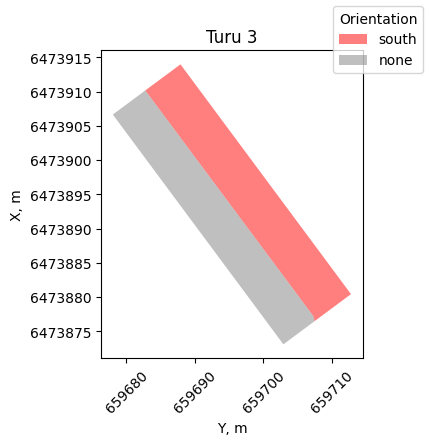

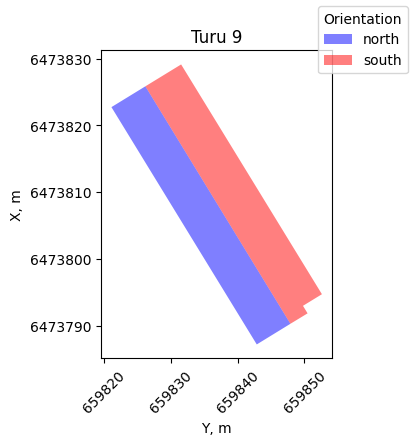

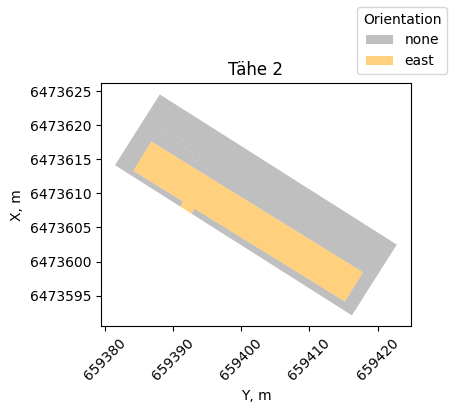

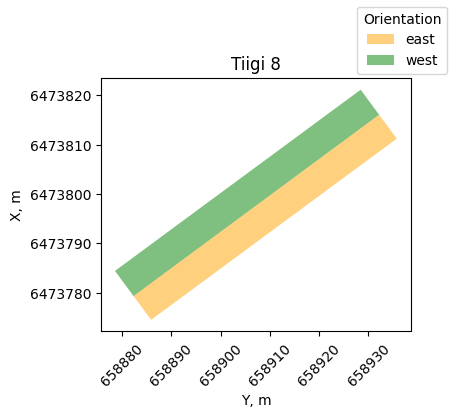

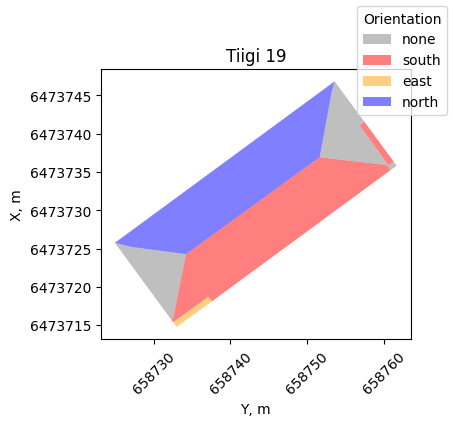

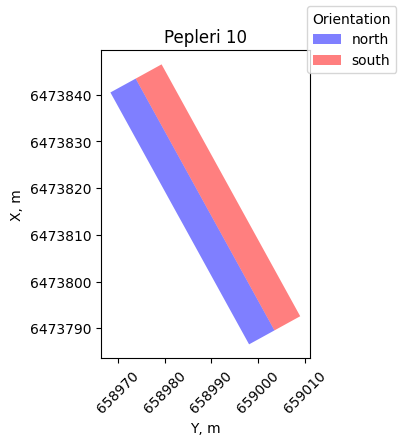

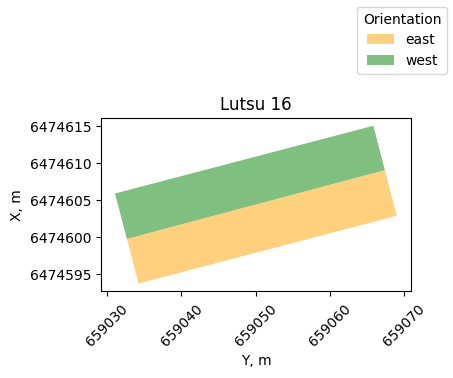

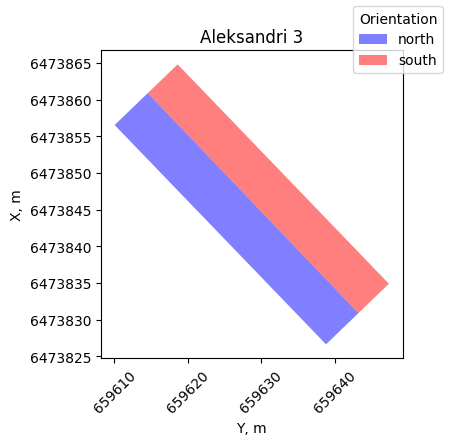

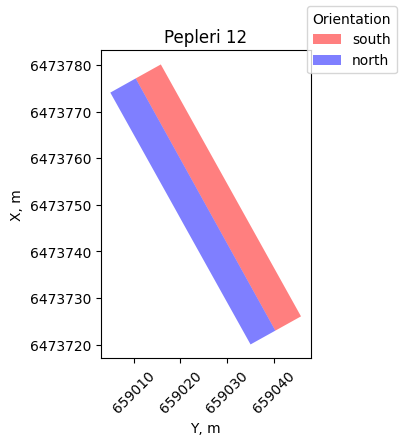

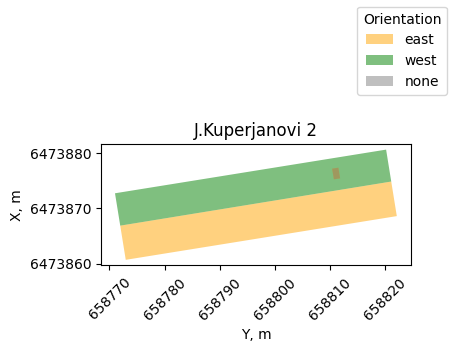

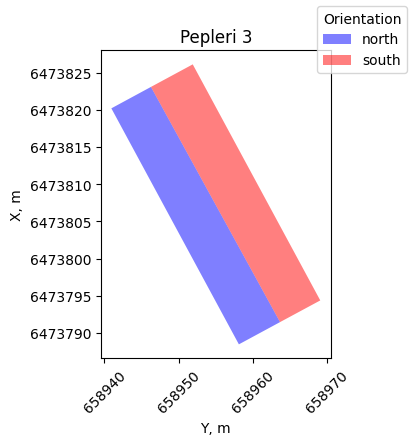

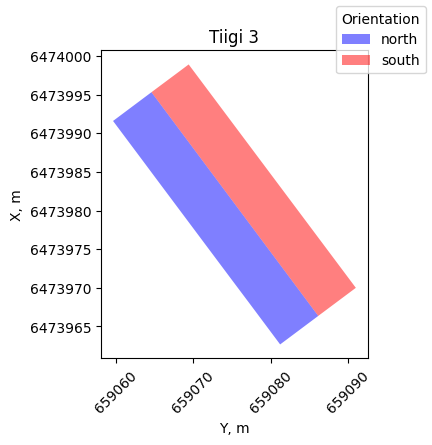

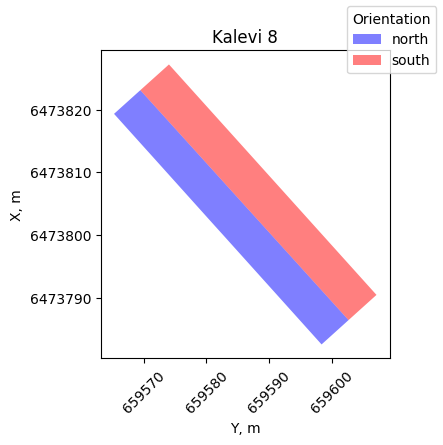

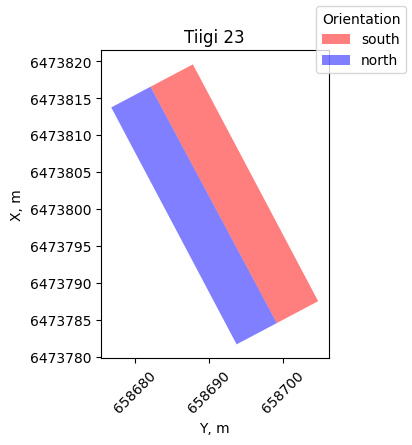

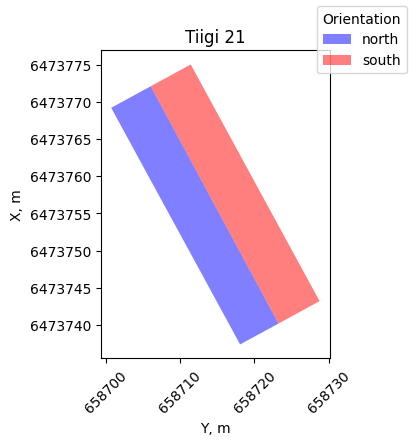

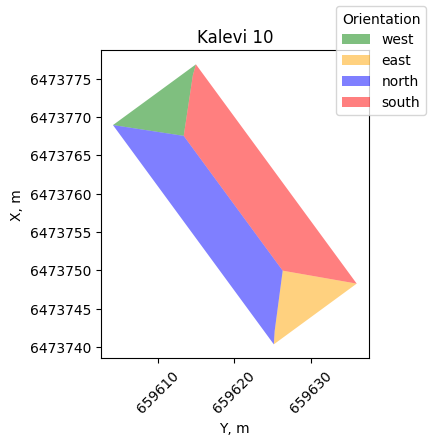

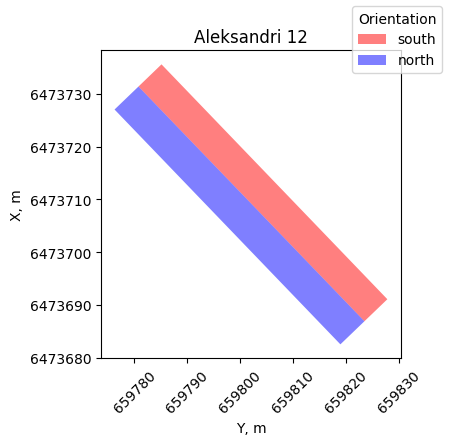

In [16]:
visualization.plot_roofs(groups, COLOR, ORIENTATION)


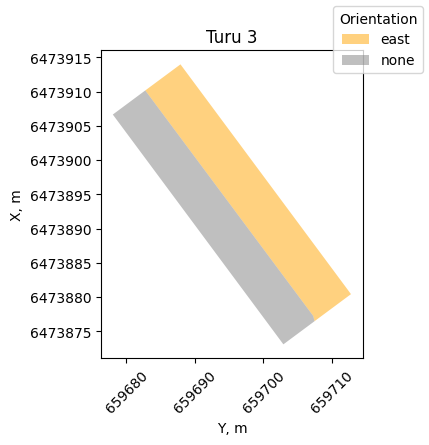

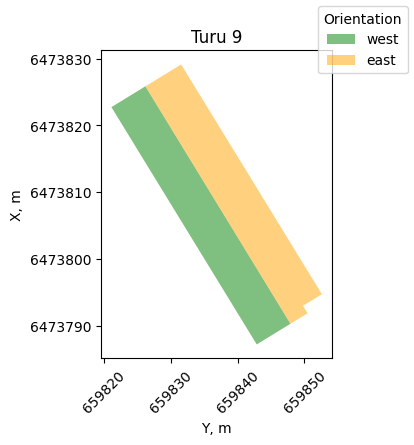

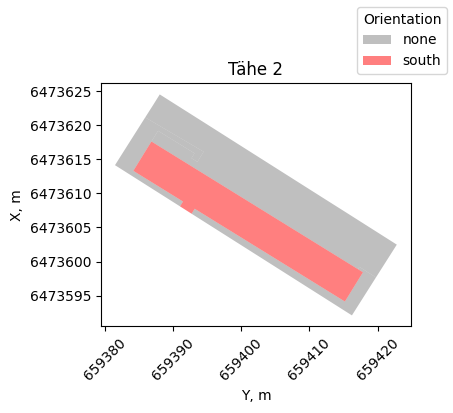

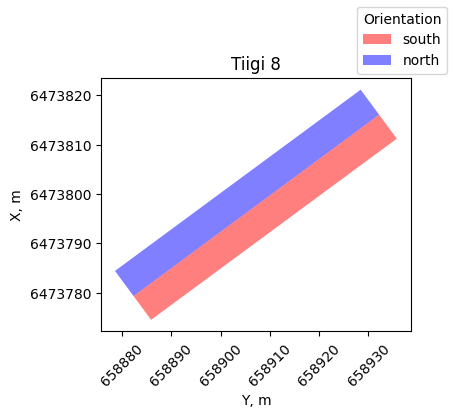

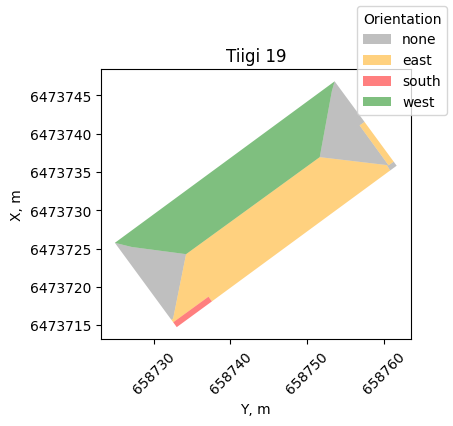

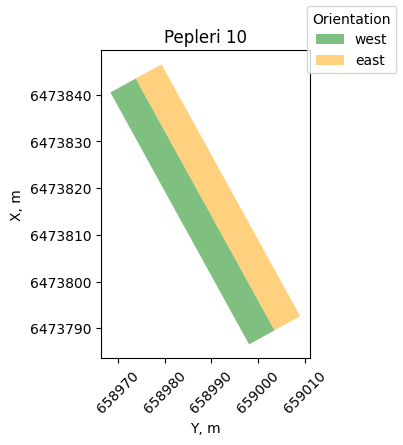

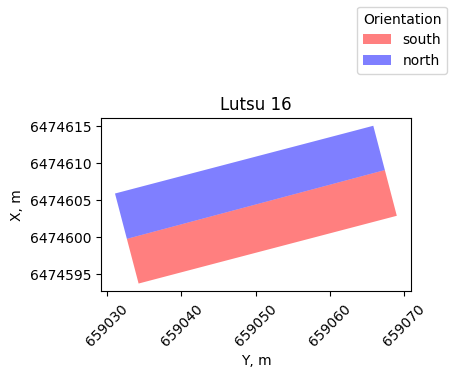

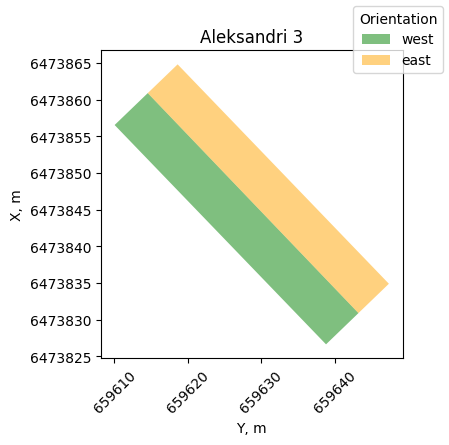

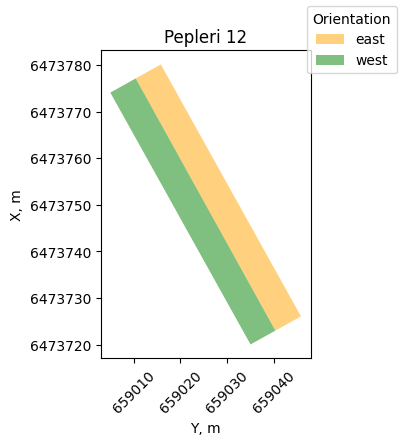

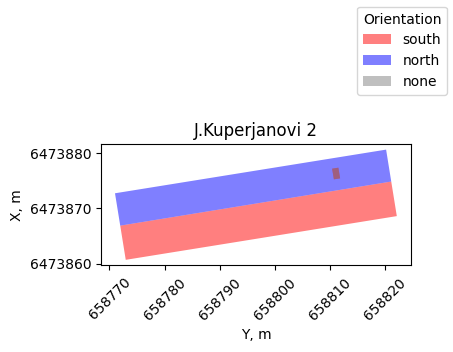

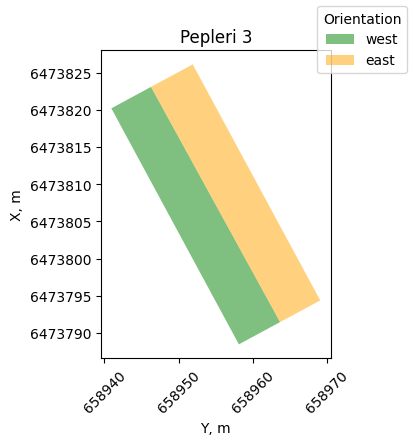

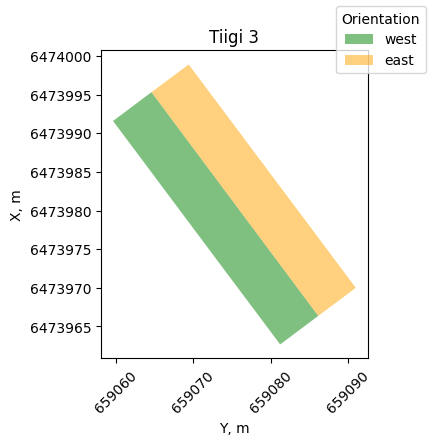

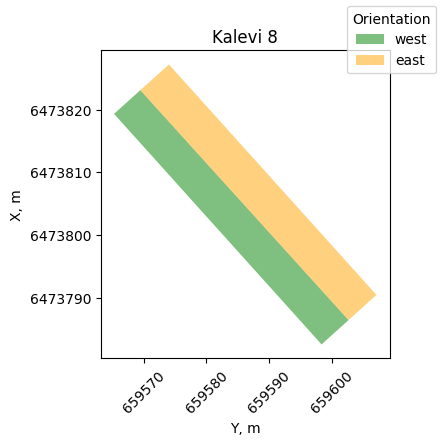

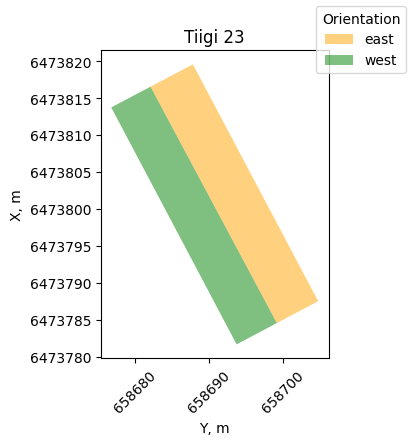

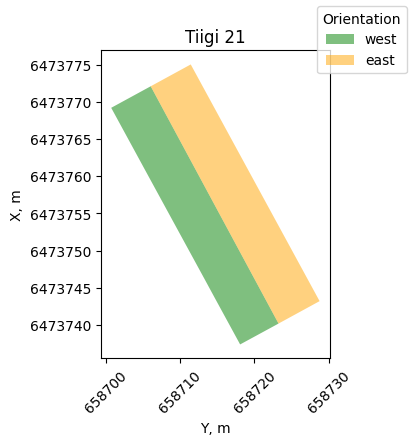

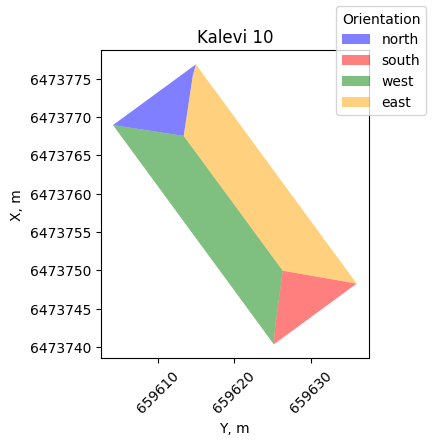

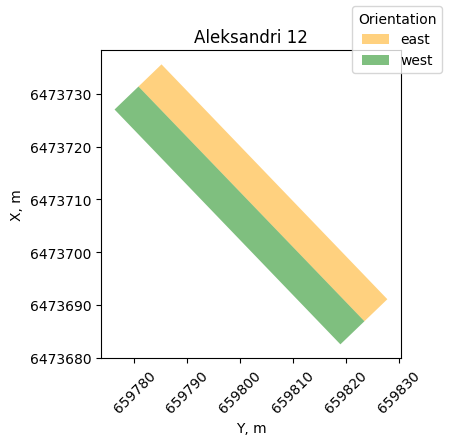

In [17]:
visualization.plot_roofs(groups, COLOR_NEW, ORIENTATION_NEW)


### Experimenting with PVGIS API

In [18]:
real_roofs_filtered = real_roofs_with_address.groupby(ETAK_ID).apply(
    lambda group: data_processing.filter_roofs_by_orientation(group, ORIENTATION, real_roofs_measures)).reset_index(drop=True)


In [19]:
real_roofs_filtered_final = real_roofs_filtered.groupby([ETAK_ID, ORIENTATION]).apply(
    utils.filter_roofs_by_coordnates).reset_index(drop=True)


In [20]:
real_roofs_filtered.shape


(22, 28)

In [21]:
real_roofs_filtered_final.shape


(21, 28)

In [22]:
result = []
for roof in real_roofs_filtered_final.iterrows():
    lat = roof[1][LAT]
    lon = roof[1][LON]
    usable_roof_area = roof[1][ROOF_AREA] * ROOF_AREA_PV_RATIO
    peak_power = usable_roof_area * 0.21
    loss = 0.14
    angle = roof[1][TILT]
    aspect = roof[1][AZIMUTH_NEW]

    outputs = utils.get_production_estimation(
        lat, lon, peak_power, loss, angle, aspect)

    result.append(utils.create_entry(
        roof[1], outputs, AZIMUTH_NEW, ORIENTATION_NEW))


In [23]:
new_production_result = pd.DataFrame(result)


In [24]:
new_production_result

,etak_id,roof_id,azimuth,orientation,annual_kwh,monthly_average_kwh,y-y_variation,Jan_kwh,Feb_kwh,Mar_kwh,Apr_kwh,May_kwh,Jun_kwh,Jul_kwh,Aug_kwh,Sep_kwh,Oct_kwh,Nov_kwh,Dec_kwh
0,713413,26251,53.325412,none,50195.38,4182.95,2669.78,1044.37,2542.44,4589.11,6034.93,7308.10,6945.55,6973.88,6081.51,4553.21,2562.35,929.19,630.75
1,715116,21107,58.594584,west,46198.80,3849.90,1965.64,534.77,1616.54,3661.64,5653.24,7436.25,7433.21,7320.28,5919.10,3894.95,1877.59,566.46,284.77
2,716647,122,31.451684,south,35317.96,2943.16,1565.44,464.03,1326.58,2874.83,4300.06,5602.36,5558.42,5483.38,4482.39,3009.55,1493.22,469.31,253.84
3,716801,28606,-36.575612,south,72413.57,6034.46,3249.48,1014.19,2808.72,5990.34,8715.67,11450.78,11294.99,11123.45,9125.40,6208.16,3121.94,993.33,566.60
4,719155,73472,57.669324,none,8514.96,709.58,452.80,177.38,431.47,778.43,1023.68,1239.46,1177.93,1182.77,1031.51,772.33,434.91,158.08,107.00
5,719155,73474,-126.347458,none,9721.88,810.16,516.98,202.53,492.63,888.77,1168.77,1415.14,1344.90,1350.42,1177.72,881.81,496.55,180.49,122.16
6,719155,73473,-78.283438,east,33204.66,2767.05,1293.91,315.76,1019.95,2556.43,4001.86,5512.88,5565.55,5427.51,4292.08,2740.74,1260.62,353.66,157.63
7,719155,73476,-125.987840,east,953.20,79.43,28.77,5.84,19.48,63.22,110.25,167.69,178.32,169.36,125.66,72.92,30.16,7.45,2.84
8,719414,59942,61.161049,west,70262.82,5855.24,2955.21,793.98,2415.68,5535.66,8596.01,11346.62,11368.28,11184.11,9018.36,5905.34,2832.74,850.04,416.01
9,719935,23825,-14.893083,south,44590.83,3715.90,2053.76,634.90,1779.00,3728.00,5386.70,7002.86,6879.82,6798.21,5610.62,3847.92,1956.34,621.48,344.99


In [25]:
new_production_result.to_csv(NEW_ROOFS_PROD_PATH, index=False)


In [26]:
recalculated_production = pd.read_csv(NEW_ROOFS_PROD_PATH)


In [27]:
columns = [ETAK_ID, ROOF_ID, AZIMUTH, ORIENTATION, ANNUAL_KWH]


In [28]:
comparison_df = real_roofs_filtered_final[columns + MONTHS_ABBR_UNITS + [PV_AREA_M2]].merge(
    recalculated_production[columns + MONTHS_ABBR_UNITS + ["y-y_variation"]],
    on=[ETAK_ID, ROOF_ID],
    how="left",
    suffixes=("", SUFFIX_NEW)
)


In [29]:
shortened_comparison = comparison_df.loc[:, columns + [AZIMUTH_NEW, ORIENTATION_NEW, ANNUAL_KWH_NEW, "y-y_variation", PV_AREA_M2]]
shortened_comparison


,etak_id,roof_id,azimuth,orientation,annual_kwh,azimuth_new,orientation_new,annual_kwh_new,y-y_variation,pv_area_m2
0,713413,26251,-143.325412,none,50131.54,53.325412,none,50195.38,2669.78,225.709026
1,715116,21107,-148.594584,north,34597.89,58.594584,west,46198.80,1965.64,236.469820
2,716647,122,-121.451684,east,28146.87,31.451684,south,35317.96,1565.44,173.824774
3,716801,28606,-53.424388,east,69962.32,-36.575612,south,72413.57,3249.48,355.023124
4,719155,73472,-147.669324,none,8504.13,57.669324,none,8514.96,452.80,38.284171
5,719155,73474,36.347458,none,9709.52,-126.347458,none,9721.88,516.98,43.710599
6,719155,73473,-11.716562,south,36294.22,-78.283438,east,33204.66,1293.91,180.620043
7,719155,73476,35.987840,south,1733.65,-125.987840,east,953.20,28.77,8.447831
8,719414,59942,-151.161049,north,53160.02,61.161049,west,70262.82,2955.21,362.314834
9,719935,23825,-75.106917,east,39863.72,-14.893083,south,44590.83,2053.76,214.508515


In [30]:
shortened_comparison.to_csv(WD.joinpath("output/production_comparison.csv"), index=False)


In [31]:
condition_orientation = shortened_comparison[ORIENTATION] != NONE


In [32]:
grouped_by_orientation = shortened_comparison[condition_orientation].groupby(
    ORIENTATION)
grouped_by_orientation[ORIENTATION_NEW].unique()


orientation
east     [south]
north     [west]
south     [east]
Name: orientation_new, dtype: object

In [33]:
for group in grouped_by_orientation:
    for direction in group[1][ORIENTATION_NEW].unique():
        data = group[1][group[1][ORIENTATION_NEW] == direction]
        difference = data[ANNUAL_KWH_NEW] / data[ANNUAL_KWH]
        print(
            f"Group {group[0]} -> {direction}: difference in annual kwh {abs(1 - difference.mean()) * 100:.2f}%")


Group east -> south: difference in annual kwh 11.94%
Group north -> west: difference in annual kwh 35.12%
Group south -> east: difference in annual kwh 26.77%


In [34]:
print(f"Average difference {((shortened_comparison[condition_orientation][ANNUAL_KWH_NEW] / shortened_comparison[condition_orientation][ANNUAL_KWH]).mean() - 1) * 100:.2f}%")


Average difference 21.81%


In [35]:
result_per_m2 = []
for roof in real_roofs_filtered_final.iterrows():
    lat = roof[1][LAT]
    lon = roof[1][LON]
    peak_power = 1 * 0.21
    loss = 0.14
    angle = roof[1][TILT]
    aspect = roof[1][AZIMUTH_NEW]

    outputs = utils.get_production_estimation(
        lat, lon, peak_power, loss, angle, aspect)

    result_per_m2.append(utils.create_entry(
        roof[1], outputs, AZIMUTH_NEW, ORIENTATION_NEW))

new_production_result_per_m2 = pd.DataFrame(result_per_m2)
comparison_per_m2 = shortened_comparison.merge(new_production_result_per_m2[[ETAK_ID, ROOF_ID, ANNUAL_KWH]], on=[ETAK_ID, ROOF_ID], how="left", suffixes=("", "_m2"))
print("1) Requesting production per one square meter: MAPE=")
print(mean_absolute_percentage_error(comparison_per_m2[ANNUAL_KWH_NEW] / comparison_per_m2[PV_AREA_M2], comparison_per_m2[ANNUAL_KWH + "_m2"]))


1) Requesting production per one square meter: MAPE=
1.533524759851929e-05


In [36]:

result_coordinates_const = []
for roof in real_roofs_filtered_final.iterrows():
    peak_power = 1 * 0.21
    loss = 0.14
    angle = roof[1][TILT]
    aspect = roof[1][AZIMUTH_NEW]

    outputs = utils.get_production_estimation(
        TARTU_LAT, TARTU_LON, peak_power, loss, angle, aspect)

    result_coordinates_const.append(utils.create_entry(
        roof[1], outputs, AZIMUTH_NEW, ORIENTATION_NEW))

new_production_result_coordinates_const = pd.DataFrame(result_coordinates_const)
comparison_coordinates_const = shortened_comparison.merge(new_production_result_coordinates_const[[ETAK_ID, ROOF_ID, ANNUAL_KWH]], on=[ETAK_ID, ROOF_ID], how="left", suffixes=("", "_m2"))
print("2) Requesting production with the same coordinates for all roofs: MAPE=")
print(mean_absolute_percentage_error(comparison_coordinates_const[ANNUAL_KWH_NEW] / comparison_coordinates_const[PV_AREA_M2], comparison_coordinates_const[ANNUAL_KWH + "_m2"]))


2) Requesting production with the same coordinates for all roofs: MAPE=
0.0004938784856399184


In [40]:

coordinates_list = [(58.401, 26.723), (58.342, 26.722), (58.376, 26.780), (58.367, 26.655), (58.376, 26.726)]
result_coordinates_mixed = []
for coordinates in coordinates_list:
    peak_power = 1 * 0.21
    loss = 0.14
    angle = 35
    aspect = 12

    outputs = utils.get_production_estimation(coordinates[0], coordinates[1], peak_power, loss, angle, aspect)

    entry = {
        "lat": coordinates[0],
        "lon": coordinates[1],
        ANNUAL_KWH + "_m2": outputs["totals"]["fixed"]["E_y"] or 0
    }

    result_coordinates_mixed.append(entry)

result_coordinates_mixed_df = pd.DataFrame(result_coordinates_mixed)
difference = (result_coordinates_mixed_df[ANNUAL_KWH + "_m2"].std() / result_coordinates_mixed_df[ANNUAL_KWH + "_m2"].mean()) * 100
print(f"Difference in annual kwh per m2 between 5 measurements: {difference:.4f}%")


Difference in annual kwh per m2 between 5 measurements: 0.1022%


In [41]:
result_coordinates_mixed_df[ANNUAL_KWH + "_m2"].std() / result_coordinates_mixed_df[ANNUAL_KWH + "_m2"].mean()

0.0010216910687576618

In [39]:
result_coordinates_mixed_df.describe()

,lat,lon,annual_kwh_m2
count,5.000000,5.000000,5.000000
mean,58.372400,26.721200,220.234000
std,0.021197,0.044347,0.225011
min,58.342000,26.655000,219.840000
25%,58.367000,26.722000,220.270000
50%,58.376000,26.723000,220.310000
75%,58.376000,26.726000,220.360000
max,58.401000,26.780000,220.390000


In [37]:
angles_optimized_result = []
for roof in real_roofs_filtered_final.iterrows():
    lat = roof[1][LAT]
    lon = roof[1][LON]
    usable_roof_area = roof[1][ROOF_AREA] * ROOF_AREA_PV_RATIO
    peak_power = usable_roof_area * 0.21
    loss = 0.14
    angle = roof[1][TILT]
    aspect = roof[1][AZIMUTH_NEW]

    outputs = utils.get_production_estimation(
        lat, lon, peak_power, loss, angle, aspect, True)

    angles_optimized_result.append(utils.create_entry(
        roof[1], outputs, AZIMUTH_NEW, ORIENTATION_NEW))

new_prod_angles_optimized_result = pd.DataFrame(angles_optimized_result)
new_prod_angles_optimized_comparison = shortened_comparison.merge(new_prod_angles_optimized_result[[ETAK_ID, ROOF_ID, ANNUAL_KWH]], on=[ETAK_ID, ROOF_ID], how="left", suffixes=("", "_optimized"))

In [38]:
new_prod_angles_optimized_result

,etak_id,roof_id,azimuth,orientation,annual_kwh,monthly_average_kwh,y-y_variation,Jan_kwh,Feb_kwh,Mar_kwh,Apr_kwh,May_kwh,Jun_kwh,Jul_kwh,Aug_kwh,Sep_kwh,Oct_kwh,Nov_kwh,Dec_kwh
0,713413,26251,53.325412,none,50195.38,4182.95,2669.78,1044.37,2542.44,4589.11,6034.93,7308.10,6945.55,6973.88,6081.51,4553.21,2562.35,929.19,630.75
1,715116,21107,58.594584,west,52575.43,4381.29,2797.96,1088.34,2662.50,4806.58,6322.07,7657.34,7277.81,7307.20,6371.46,4769.80,2681.80,970.02,660.50
2,716647,122,31.451684,south,38660.10,3221.68,2055.78,805.23,1958.84,3534.23,4647.87,5627.57,5348.25,5370.23,4683.41,3506.60,1974.52,717.67,485.68
3,716801,28606,-36.575612,south,78963.27,6580.27,4199.08,1645.04,4001.28,7218.77,9493.07,11494.01,10923.43,10968.33,9565.64,7162.23,4033.14,1466.04,992.30
4,719155,73472,57.669324,none,8514.96,709.58,452.80,177.38,431.47,778.43,1023.68,1239.46,1177.93,1182.77,1031.51,772.33,434.91,158.08,107.00
5,719155,73474,-126.347458,none,9721.88,810.16,516.98,202.53,492.63,888.77,1168.77,1415.14,1344.90,1350.42,1177.72,881.81,496.55,180.49,122.16
6,719155,73473,-78.283438,east,40172.55,3347.71,2136.26,836.88,2035.62,3672.55,4829.57,5847.63,5557.35,5580.18,4866.53,3643.78,2051.84,745.82,504.80
7,719155,73476,-125.987840,east,1878.92,156.58,99.92,39.14,95.21,171.77,225.89,273.50,259.92,260.99,227.61,170.42,95.97,34.88,23.61
8,719414,59942,61.161049,west,80584.66,6715.39,4285.26,1678.81,4083.44,7367.03,9687.88,11730.08,11147.78,11193.57,9762.02,7309.28,4115.96,1496.13,1012.67
9,719935,23825,-14.893083,south,47525.43,3960.45,2547.05,943.98,2389.50,4351.58,5732.10,6953.12,6611.01,6635.65,5780.91,4323.32,2417.46,847.24,539.55


In [39]:
condition_orientation = new_prod_angles_optimized_comparison[ORIENTATION] != NONE
print(f"Average difference {((new_prod_angles_optimized_comparison[condition_orientation][ANNUAL_KWH + '_optimized'] / new_prod_angles_optimized_comparison[condition_orientation][ANNUAL_KWH_NEW]).mean() - 1) * 100:.2f}%")


Average difference 16.61%


### Comparing roofs sizes


In [66]:
pv_area_comparison_df = real_roofs_measures.merge(
    real_roofs_filtered_final.loc[:, [
        ETAK_ID, ROOF_ID, ORIENTATION, ORIENTATION_NEW, ROOF_AREA, PV_AREA_M2]],
    on=[ETAK_ID, ORIENTATION],
    how="left",
    suffixes=(SUFFIX_REAL, SUFFIX_ESTIMATED)
)


In [67]:
pv_area_comparison_df.loc[0, ROOF_AREA] += pv_area_comparison_df.loc[1, ROOF_AREA]
pv_area_comparison_df.loc[0, PV_AREA_M2 + SUFFIX_ESTIMATED] = pv_area_comparison_df.loc[0, ROOF_AREA] * ROOF_AREA_PV_RATIO
pv_area_comparison_df.drop(1, inplace=True)


In [68]:
condition_id_real_roofs = (real_roofs[ETAK_ID] == 716647)
condition_id_comparison = (pv_area_comparison_df[ETAK_ID] == 716647)


In [69]:
pv_area_comparison_df.loc[condition_id_comparison, ORIENTATION_NEW] = NONE
pv_area_comparison_df.loc[condition_id_comparison, PV_AREA_M2 +
                          SUFFIX_ESTIMATED] = real_roofs.loc[condition_id_real_roofs, PV_AREA_M2].sum()
pv_area_comparison_df.loc[condition_id_comparison,
                          ROOF_AREA] = real_roofs.loc[condition_id_real_roofs, ROOF_AREA].sum()


In [70]:
pv_area_comparison_df


,address,etak_id,orientation,pv_area_m2_real,roof_id,orientation_new,roof_area,pv_area_m2_estimated
0,Tiigi 19,719155,south,172.34,73473,east,210.075415,189.067874
2,Tiigi 19,719155,none,26.64,73472,none,42.537967,38.284171
3,Tiigi 19,719155,none,26.64,73474,none,48.567332,43.710599
4,Tähe 2,716647,east,182.69,122,none,513.180211,461.862190
5,Aleksandri 3,720043,north,146.65,34938,west,271.145903,244.031313
6,Pepleri 10,719414,north,169.67,59942,west,402.572038,362.314834
7,Turu 9,715116,north,147.85,21107,west,262.744245,236.469820
8,Turu 3,713413,none,165.44,26251,none,250.787806,225.709026
9,Pepleri 3,720467,north,139.91,72262,west,236.358032,212.722229
10,Kalevi 10,721071,north,96.41,8415,west,217.617685,195.855917


In [71]:
condition_orientation = pv_area_comparison_df[ORIENTATION_NEW] == NONE


In [82]:
mape_tilted = mean_absolute_percentage_error(pv_area_comparison_df[~condition_orientation][PV_AREA_M2 + SUFFIX_REAL], pv_area_comparison_df[~condition_orientation][PV_AREA_M2 + SUFFIX_ESTIMATED])
mape_tilted

0.5662293320791737

In [83]:
mape_flat = mean_absolute_percentage_error(pv_area_comparison_df[condition_orientation][PV_AREA_M2 + SUFFIX_REAL], pv_area_comparison_df[condition_orientation][PV_AREA_M2 + SUFFIX_ESTIMATED])
mape_flat

0.7425742033846097

In [94]:
mean_absolute_percentage_error(
    pv_area_comparison_df[PV_AREA_M2 + SUFFIX_REAL],
    pv_area_comparison_df[PV_AREA_M2 + SUFFIX_ESTIMATED]
)

0.6014983063402608

In [78]:
grouped_comparison = pv_area_comparison_df.groupby(ORIENTATION_NEW)
coefficients = {}
for group in grouped_comparison:
    coefficients[group[0]] = (
        group[1][PV_AREA_M2 + SUFFIX_ESTIMATED] / group[1][PV_AREA_M2 + SUFFIX_REAL]).mean()


In [79]:
coefficients


{'east': 1.0970632106165839,
 'none': 1.7425742033846097,
 'south': 1.4028356624057696,
 'west': 1.6682966775479195}

In [80]:
for key, value in coefficients.items():
    pv_area_comparison_df.loc[pv_area_comparison_df[ORIENTATION_NEW] == key, PV_AREA_M2 +
                              SUFFIX_NEW] = pv_area_comparison_df.loc[pv_area_comparison_df[ORIENTATION_NEW] == key, PV_AREA_M2 + SUFFIX_ESTIMATED] / value


In [84]:
pv_area_comparison_df.loc[condition_orientation, PV_AREA_M2 +
                          SUFFIX_NEW] = pv_area_comparison_df.loc[condition_orientation, PV_AREA_M2 + SUFFIX_ESTIMATED] * mape_flat


In [90]:
pv_area_comparison_df.loc[~condition_orientation, PV_AREA_M2 +
                          SUFFIX_NEW] = pv_area_comparison_df.loc[~condition_orientation, PV_AREA_M2 + SUFFIX_ESTIMATED] * mape_tilted


In [95]:
print(f"On average, pv area comprises {(pv_area_comparison_df[condition_orientation][PV_AREA_M2 + SUFFIX_REAL] / pv_area_comparison_df[condition_orientation][ROOF_AREA]).mean() * 100:.2f}% of flat roof area.")


On average, pv area comprises 54.76% of flat roof area.


In [97]:
print(f"On average, pv area comprises {(pv_area_comparison_df[~condition_orientation][PV_AREA_M2 + SUFFIX_REAL] / pv_area_comparison_df[~condition_orientation][ROOF_AREA]).mean() * 100:.2f}% of tilted roof area.")


On average, pv area comprises 59.56% of tilted roof area.


In [86]:
print(f"On average, pv area comprises {(pv_area_comparison_df[PV_AREA_M2 + SUFFIX_REAL] / pv_area_comparison_df[ROOF_AREA]).mean() * 100:.2f}% of roof area.")


On average, pv area comprises 58.60% of roof area.


In [91]:
pv_area_comparison_df


,address,etak_id,orientation,pv_area_m2_real,roof_id,orientation_new,roof_area,pv_area_m2_estimated,pv_area_m2_new
0,Tiigi 19,719155,south,172.34,73473,east,210.075415,189.067874,107.055776
2,Tiigi 19,719155,none,26.64,73472,none,42.537967,38.284171,28.428837
3,Tiigi 19,719155,none,26.64,73474,none,48.567332,43.710599,32.458363
4,Tähe 2,716647,east,182.69,122,none,513.180211,461.862190,342.966948
5,Aleksandri 3,720043,north,146.65,34938,west,271.145903,244.031313,138.177687
6,Pepleri 10,719414,north,169.67,59942,west,402.572038,362.314834,205.153286
7,Turu 9,715116,north,147.85,21107,west,262.744245,236.469820,133.896148
8,Turu 3,713413,none,165.44,26251,none,250.787806,225.709026,167.605700
9,Pepleri 3,720467,north,139.91,72262,west,236.358032,212.722229,120.449565
10,Kalevi 10,721071,north,96.41,8415,west,217.617685,195.855917,110.899365


In [92]:
mean_squared_error(pv_area_comparison_df[PV_AREA_M2 + SUFFIX_REAL],
                   pv_area_comparison_df[PV_AREA_M2 + SUFFIX_NEW], squared=False)


48.904956845099754

In [93]:
mean_absolute_percentage_error(pv_area_comparison_df[PV_AREA_M2 + SUFFIX_REAL],
                   pv_area_comparison_df[PV_AREA_M2 + SUFFIX_NEW])

0.2043878292105356

### Recalculating azimuth

In [53]:
roofs_data = estimated_production_by_roof.loc[:, [ETAK_ID, ROOF_ID, TILT, AZIMUTH, ORIENTATION, ROOF_AREA, POINTS]]

In [54]:
roofs_data[POINTS] = roofs_data[POINTS].apply(lambda x: ast.literal_eval(x))
roofs_data[AZIMUTH_NEW] = roofs_data[POINTS].apply(lambda x: data_processing.get_angles(data_processing.unit_normal(x[0], x[1], x[2]))[0])
roofs_data[ORIENTATION_NEW] = roofs_data.apply(data_processing.get_orientation, axis=1)

grouped_by_orientation = roofs_data[roofs_data[ORIENTATION] != NONE].groupby(ORIENTATION)
grouped_by_orientation[ORIENTATION_NEW].unique()


orientation
east      [south, east, west]
north    [west, north, south]
south    [east, north, south]
west      [north, west, east]
Name: orientation_new, dtype: object

In [240]:
roofs_data.to_csv(RECALCULATED_ROOFS_PATH, index=False)
